Notebook sobre correções às versões dos mapas entregue ao CIBIO a 4/09. 

Objetivo - incluir mais cidades do país, e representação não apenas por pontos, mas também desenhando as boundaries de cidades/vilas.

* __Earth engine script:__ polygons

Notas: Polígonos 15 e 16 (começando a contar em 1) correspondem ambos a Gabú, então criou-se função auxiliar _correct_multipolygon()_ para juntar esses dois num só de Gabú inteiro.

* __Acontecimentos:__
    * Criação do multipolygon _cities_ no script _polygons_ do ee e exportação. CRS default já é __EPSG:4326__. Resultado guardado em __cities_multipolygon.geojson__.
    * Correção de Gabu com _correct_multipolygon()_, guardado em __cities_corrected_gabu().geojson__.
    * _get_centroids()_ para obter os centroides de cada polígono e usar como pontos, em vez dos pontos de cities.csv.
* __Dificuldades:__
    * Em acrescentar ao código já criado a parte do overlay das regiões (polígonos) no land cover map. Foi preciso ir buscar os pontos que definem o exterior, e preencher com _plt.fill()_.
    * Na passagem de Multipolygon dataframe para um dataframe com vários polygons individuais.

<a id="top"></a>
____
# Top

Auxiliary functions

<a href="#thefunction"> 1. The important function</a>

<a href="#cashewnon"> 2. Function for cashew vs. non</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap  # Add this import

import rasterio
from rasterio.plot import show

#UPDATED CITIES

## Bissau e Bissorã estão muito um em cima do outro. Tirar um para não haver tanta sobreposição.
cities = pd.read_csv("cities.csv")

In [2]:
import numpy as np
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union

def correct_multipolygon(geoJSON_path = "cities_multipolygon.geojson", save=False, output_geojson_path = "cities_corrected_gabu.geojson"):

    gdf = gpd.read_file(geoJSON_path)
    gdf_exploded = gdf.explode(index_parts=False)
    polygons = list(gdf_exploded['geometry'])
    
    polygons_corrected = []
    
    for i,polygon in enumerate(polygons):
        if i == 15:
            new = unary_union([polygons[i],polygons[i+1]]) #merge polygon 15 and 16, both parts of Gabú
            polygons_corrected.append(new)
        elif i == 16:
            continue
        else:
            polygons_corrected.append(polygon)
    
    polygons = polygons_corrected
    
    # Convert the list of polygons into a GeoDataFrame MultiPolygon
    multi_polygon = MultiPolygon(polygons)
    multi_polygon_gdf = gpd.GeoDataFrame(geometry=[multi_polygon], crs=gdf.crs)

    if save:
        multi_polygon_gdf.to_file(output_geojson_path, driver="GeoJSON")        
        print(f"MultiPolygon saved to {output_geojson_path}")

    return multi_polygon_gdf

def get_centroids(geoJSON_path = "cities_corrected_gabu.geojson",wanna_print=False):
    gdf = gpd.read_file(geoJSON_path)
    gdf_exploded = gdf.explode(index_parts=False)
    
    polygons = list(gdf_exploded['geometry'])
    
    centroids = []
    
    for i,polygon in enumerate(polygons):
        centroid = polygon.centroid
        centroids.append((centroid.x, centroid.y))

    if wanna_print:
        for i, centroid in enumerate(centroids):
            print(f"Polygon {i + 1} centroid: {centroid}")
    
    centroids = np.array(centroids)
    return centroids

In [3]:
mp = correct_multipolygon()
centroids = get_centroids()
centroids[:,0]

array([-15.61050291, -15.64528906, -15.74037578, -15.85372657,
       -15.54171196, -16.19743328, -16.16157481, -16.18974387,
       -16.04558542, -15.707499  , -15.80660986, -15.452013  ,
       -15.17163024, -15.21857458, -15.32377233, -14.22768844,
       -13.95456622, -14.14898818, -14.48311654, -14.98416886,
       -15.25327008, -14.93310708, -15.01812501, -15.11462654,
       -15.40003735, -15.48186125, -15.22854559, -15.17281974,
       -15.83520949, -15.17334886, -14.64865346, -14.8562904 ,
       -14.5693286 ])

___

<a id="thefunction"></a>

## The important function:

<a href="#top">Back to top</a>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
from matplotlib.colors import ListedColormap
import geopandas as gpd
from matplotlib.patches import Polygon

def plotmap_regions(geoTIFF_path, save=False, output_path="updated_plot", plot_regions=False, plot_cities=False,
                    geoJSON_path="cities_corrected_gabu.geojson", figsize=(10,10), dpi=600,
                    regions_color="lightgrey", cities_color="black", cities_alpha=1):
    
    """
    Plots the 1-band image containing the class of each pixel, the biggest cities in the country, either as dots or as polygons.
    output_path: name of the output
    plot_regions and plot_cities: booleans, if you want to plot the polygons and/or the dots of the cities
    geoJSON_path: a geojson containing a Multipolygon. Needed for both regions and cities
    cities_alpha: recommended when plotting both cities and polygons
    """

    if plot_regions:
        # Read the GeoJSON file to extract the multipolygon geometries
        gdf = gpd.read_file(geoJSON_path)
        gdf_exploded = gdf.explode(index_parts=False)
        polygons = list(gdf_exploded['geometry'])
        
    if plot_cities:
        centroids = get_centroids(geoJSON_path,wanna_print=False)
    
    with rasterio.open(geoTIFF_path) as src:
        image = src.read(1)  # Read the first band
    
    # Set values outside the range [1, 7] to be transparent
    masked_image = np.ma.masked_outside(image, 1, 7)
    
    palette = ['#006600', '#99ff33', '#2d8659', '#c6538c', '#808000', '#804000', '#0000ff']
    class_names = ['Closed Forest', 'Open Forest', 'Mangrove', 'Savanna', 'Cashew', 'Non-Forest', 'Water']
    vis_params = {
        "cmap": ListedColormap(palette),
        "vmin": 1,
        "vmax": 7,
        "alpha": 0.9,  # Adjust transparency (0.0 = fully transparent, 1.0 = fully opaque)
    }
    
    plt.figure(figsize=figsize, facecolor='white') #white background color
    left, bottom, right, top = src.bounds
    img = plt.imshow(masked_image, **vis_params, extent=(left, right, bottom, top))
    #src.bounds ordem é: left, bottom, right, top
    #Mas extent parameter ordem é: left, right, bottom, top. Mudar essa parte
    
    cbar = plt.colorbar(img, ticks=np.arange(1, 8), label="Class", orientation="vertical", shrink=0.4)
    cbar.set_ticklabels(class_names)
    plt.title("Guinea-Bissau land cover map 2021")
    plt.axis("off")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Plot the individual polygons as black
    if plot_regions:
        for polygon in polygons:
            coords = list(polygon.exterior.coords)
            x, y = zip(*coords) #coords is a list of tuples, zip separates all the elements in positions 0 to x, and in positions 1 to y
            plt.fill(x, y, color=regions_color)
    if plot_cities:
        plt.scatter(centroids[:,0],centroids[:,1], color=cities_color, alpha=cities_alpha)
    
    # Save the plot as a PNG image
    if save:
        plt.savefig(output_path, dpi=dpi, bbox_inches="tight")#, transparent=True)
        print(f"Plot saved as {output_path}")
    
    plt.show()

Plot saved as s2cc_7class_justcities


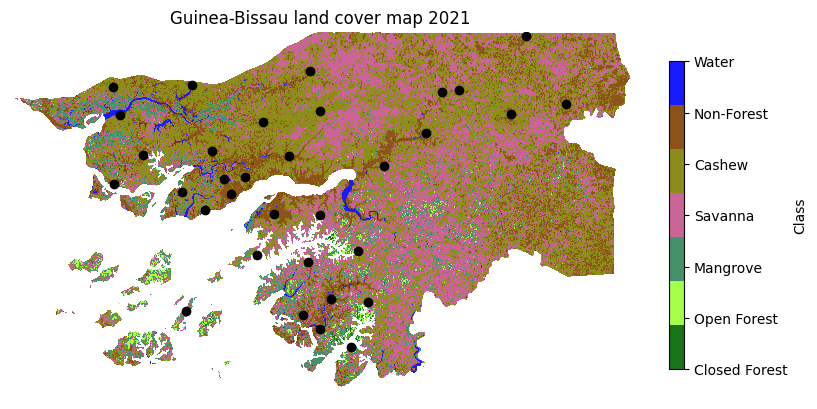

In [6]:
# Just cities

plotmap_regions(geoTIFF_path = "s2cc_0_GB_LC_CCDC_2021_7class_lonlat.tif",
                plot_cities=True, cities_color="black",
               save=True, output_path="s2cc_7class_justcities")

Plot saved as s2cc_7class_justregions


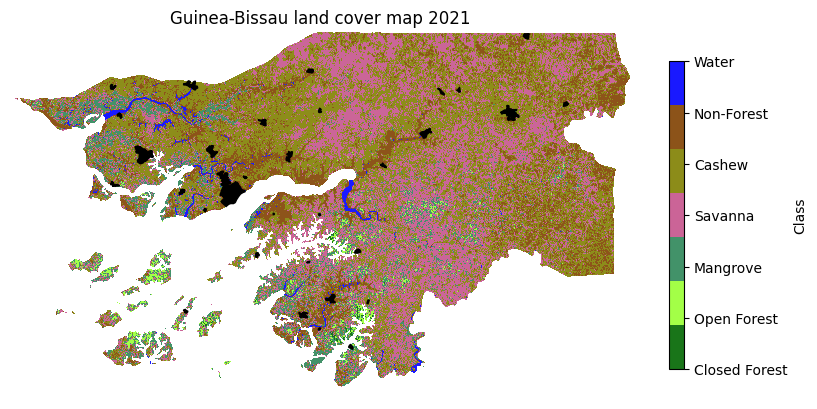

In [7]:
# Just polygons

plotmap_regions(geoTIFF_path = "s2cc_0_GB_LC_CCDC_2021_7class_lonlat.tif",
                plot_regions=True, regions_color="black",
               save=True, output_path="s2cc_7class_justregions")

<a id="cashewnon"></a>
___

# Cashew vs. non-cashew

<a href="#top">Back to top</a>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
from matplotlib.colors import ListedColormap
import geopandas as gpd
from matplotlib.patches import Polygon

def plotmap_regions_cashewnon(geoTIFF_path, save=False, output_path="updated_plot", plot_regions=False, plot_cities=False,
                    geoJSON_path="cities_corrected_gabu.geojson", figsize=(10,10), dpi=600,
                    regions_color="lightgrey", cities_color="black", cities_alpha=1):
    
    """
    Plots the 1-band image containing the class of each pixel, the biggest cities in the country, either as dots or as polygons.
    output_path: name of the output
    plot_regions and plot_cities: booleans, if you want to plot the polygons and/or the dots of the cities
    geoJSON_path: a geojson containing a Multipolygon. Needed for both regions and cities
    cities_alpha: recommended when plotting both cities and polygons
    """

    if plot_regions:
        # Read the GeoJSON file to extract the multipolygon geometries
        gdf = gpd.read_file(geoJSON_path)
        gdf_exploded = gdf.explode(index_parts=False)
        polygons = list(gdf_exploded['geometry'])
        
    if plot_cities:
        centroids = get_centroids(geoJSON_path,wanna_print=False)
    
    with rasterio.open(geoTIFF_path) as src:
        image = src.read(1)  # Read the first band

    # Cashew vs. non-cashew
    image[(image != 5) & (image != 0)] = 2 ## non-cashew - class 2
    image[image == 5] = 1 ##cashew - class 1
    masked_image = np.ma.masked_outside(image, 1, 2)

    # Visualization parameters
    palette = ['#006600', '#808000']
    class_names = ['Cashew', 'Non-Cashew']
    vis_params = {
        "cmap": ListedColormap(palette),
        "vmin": 1,
        "vmax": 2,
        "alpha": 0.9,  # Adjust transparency (0.0 to 1.0 - fully opaque)
    }
    
    plt.figure(figsize=figsize, facecolor='white') #white background color
    left, bottom, right, top = src.bounds
    img = plt.imshow(masked_image, **vis_params, extent=(left, right, bottom, top))
    #src.bounds ordem é: left, bottom, right, top
    #Mas extent parameter ordem é: left, right, bottom, top. Mudar essa parte

    cbar = plt.colorbar(img, ticks=np.arange(1, 3), label="Class", orientation="vertical", shrink=0.2)
    cbar.set_ticklabels(class_names)
    plt.title("Guinea-Bissau Cashew vs. Non-Cashew 2021")
    plt.axis("off")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Plot the individual polygons as black
    if plot_regions:
        for polygon in polygons:
            coords = list(polygon.exterior.coords)
            x, y = zip(*coords) #coords is a list of tuples, zip separates all the elements in positions 0 to x, and in positions 1 to y
            plt.fill(x, y, color=regions_color)
    if plot_cities:
        plt.scatter(centroids[:,0],centroids[:,1], color=cities_color, alpha=cities_alpha)
    
    # Save the plot as a PNG image
    if save:
        plt.savefig(output_path, dpi=dpi, bbox_inches="tight")#, transparent=True)
        print(f"Plot saved as {output_path}")
    
    plt.show()

Plot saved as s2cc_cashewnon_justcities


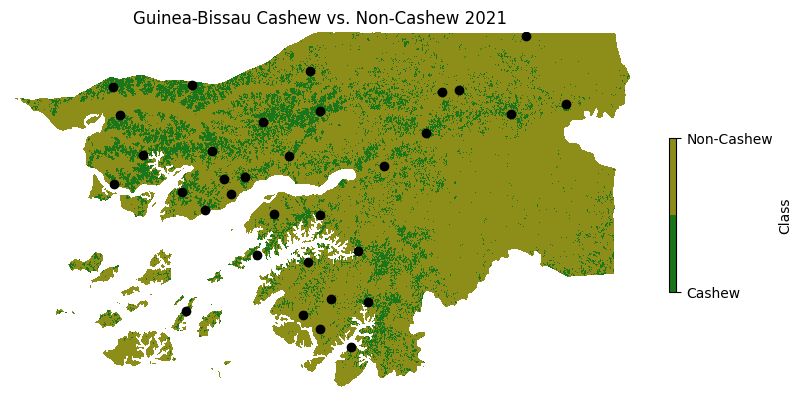

In [5]:
# Just cities

plotmap_regions_cashewnon(geoTIFF_path = "s2cc_0_GB_LC_CCDC_2021_7class_lonlat.tif",
                plot_cities=True, cities_color="black",
                save=True, output_path="s2cc_cashewnon_justcities")

Plot saved as s2cc_cashewnon_justregions


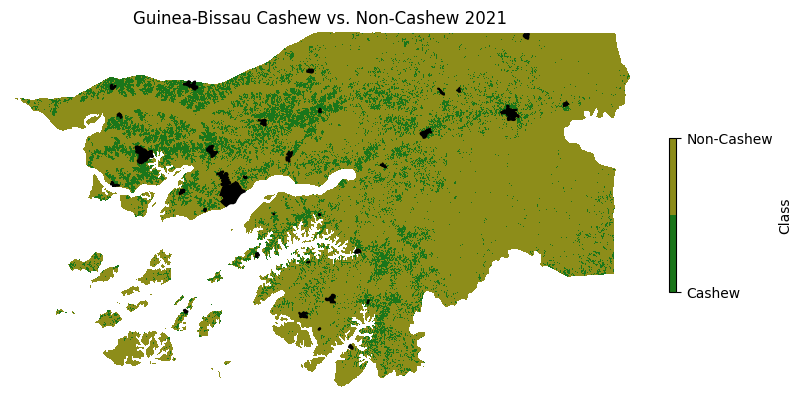

In [6]:
# Just polygons

plotmap_regions_cashewnon(geoTIFF_path = "s2cc_0_GB_LC_CCDC_2021_7class_lonlat.tif",
                plot_regions=True, regions_color="black",
               save=True, output_path="s2cc_cashewnon_justregions")